# Calculating and saving parameters

In [1]:
from Calc import open_model, save
from Parameters import *
from Geometry import *
from Calc import open_model, save
import matplotlib.pyplot as plt

In [15]:
Params['Solver_type'] = 'Fast'
Params['Threads'] = 1

for n in range(100, 101):
    Params['N'], Params['shape'] = to3D(n, 1, 1, 'zyx')
    save('DATA', Params)

Количество колец: {'z': 101, 'y': 200, 'x': 200}
Cirvecs forming


100%|██████████| 3/3 [00:00<00:00,  5.33it/s]


Circvecs: Done
FFT solving


  6%|▋         | 65/1000 [00:00<00:04, 219.87it/s]


KeyboardInterrupt: 

In [2]:
Params['N'], Params['shape'] = to3D(15, 15, 15, 'zyx')
Params['Solver_type'] = 'Fast'
save('DATA', Params)


Количество колец: {'z': 3600, 'y': 3600, 'x': 3600}
Cirvecs forming


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


Circvecs: Done
FFT solving


  0%|          | 0/1000 [00:00<?, ?it/s]


NotImplementedError: rmatvec is not defined

In [ ]:

data = open_model('DATA', Params)
plt.title(Params['shape'])
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.legend()

In [4]:
Params['N'], Params['shape'] = to3D(10, 10, 10, 'zyx')
Params['Solver_type'] = 'Straight'

In [ ]:
save('DATA', Params)

# Plotting graphs for chi

### Chi for different structures


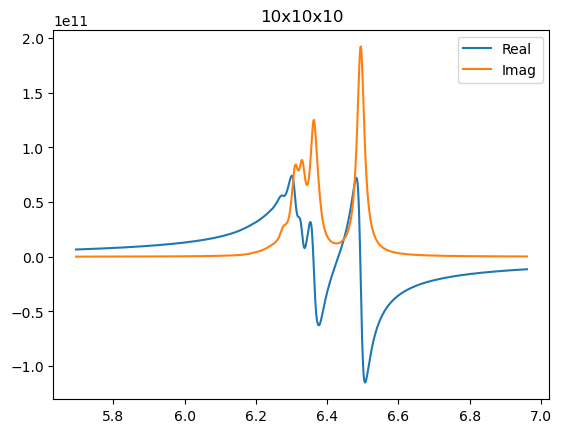

In [13]:
Params['N'], Params['shape'] = to3D(10, 10, 10, 'zyx')

Params['Solver_type'] = 'Fast'
data = open_model('DATA', Params)
plt.title(Params['shape'])
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.legend()

Params['Solver_type'] = 'Straight'
data = open_model('DATA', Params)
#plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].real, label='Real')
#plt.plot(data['Omega']/2/np.pi/1e6, data['Polarization'][:, 0].imag, label='Imag')
plt.legend()


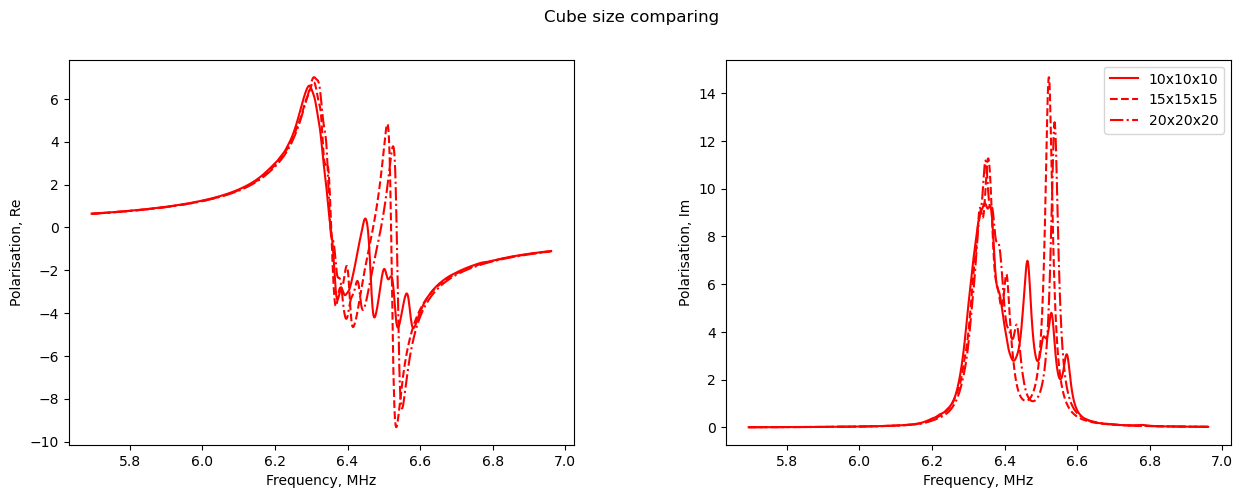

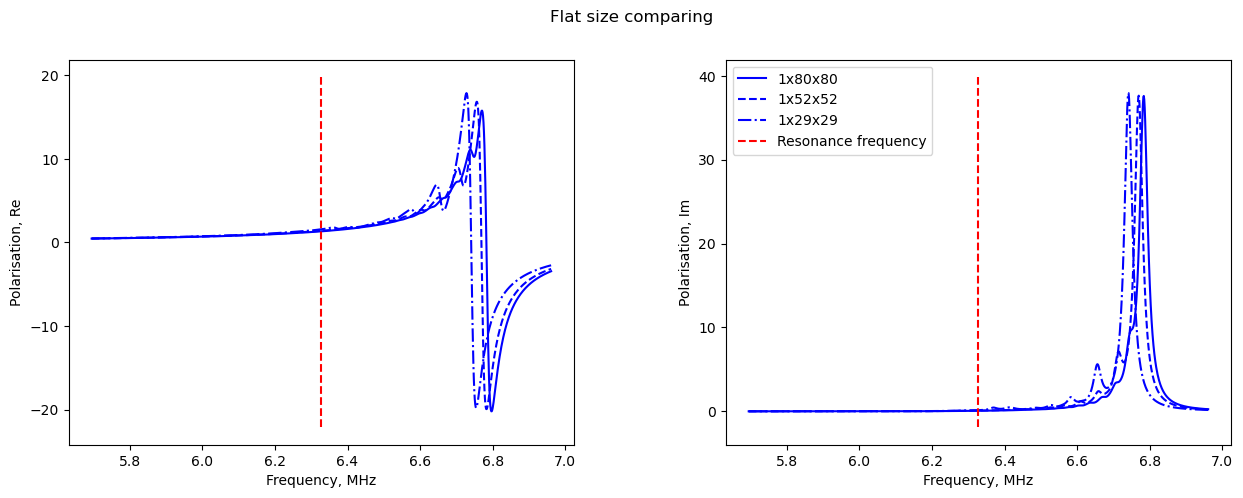

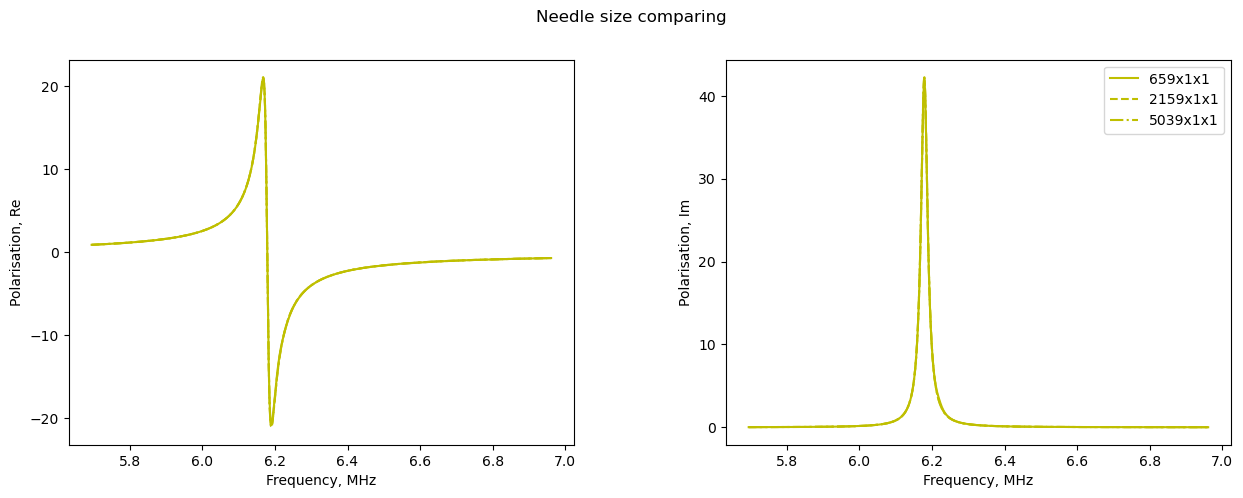

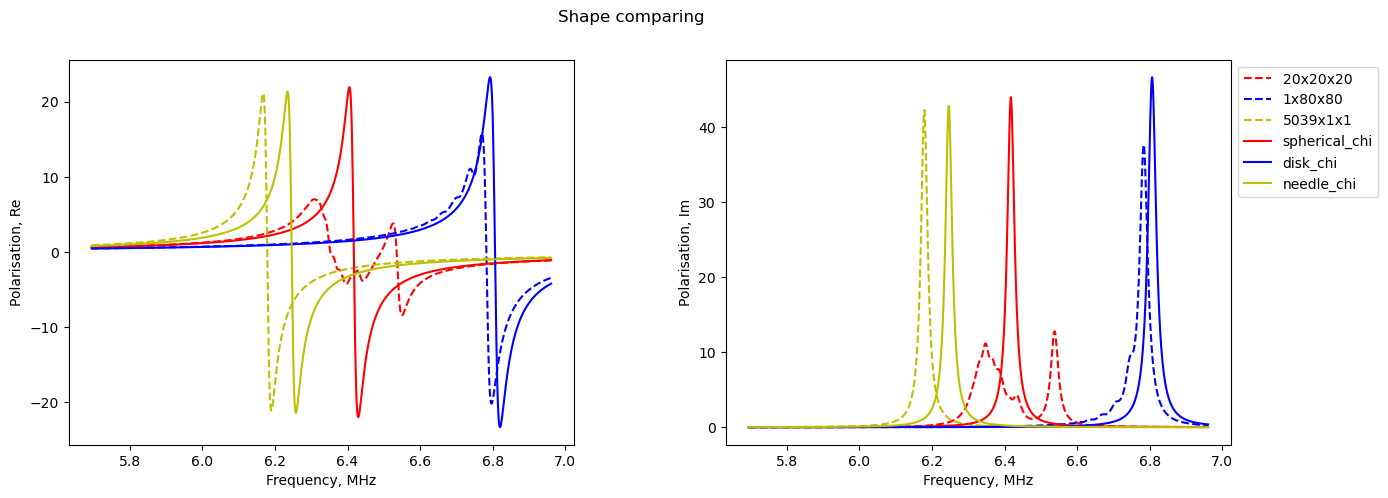

In [19]:
# Compare exact structures
import json
import numpy as np
import matplotlib.pyplot as plt
from Verifying_MRI.Parameters_MRI import Params
from Straight_Method import effective_mu, spherical_chi, disk_chi, needle_chi

omega_0 = 1/np.sqrt(Params['L'] * Params['C'])


# Compare big, average and small cube structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)   
for n, linestyle in zip([1, 1.5, 2], ['-', '--', '-.']):
    shape = f'{int(n * 10) }x{int(n * 10) }x{int(n * 10)}'
    Nz, Ny, Nx = int(n*10+1), int(n*10+1), int(n*10+1)
    Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', linestyle = linestyle, color = 'r')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.suptitle('Cube size comparing')
plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.show()

# Compare big, average and small flat structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)  
for n, linestyle in zip(['1x80x80', '1x52x52', '1x29x29'], ['-', '--', '-.']):
    shape = n
    # Nz, Ny, Nx = n+1, 32*n, 32*n
    # Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    # Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    # alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', linestyle = linestyle, color = 'b')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', linestyle = linestyle, color = 'b')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.suptitle('Flat size comparing')
plt.subplot(121)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.show()

# Compare big, average and small needle structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)  
for n, linestyle in zip(['659x1x1', '2159x1x1','5039x1x1'], ['-', '--', '-.']):
    shape = n
    # Nz, Ny, Nx = n*1000+1, n+1, n+1
    # Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    # Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    # alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"])
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', linestyle = linestyle, color = 'y')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', linestyle = linestyle, color = 'y')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

plt.suptitle('Needle size comparing')
plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend()
plt.show()

# Compare disk, needle and spherical structures
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)  
for shape, color in zip(['20x20x20', '1x80x80', '5039x1x1'], ['r', 'b', 'y']):
    Nz, Ny, Nx = [int(i) for i in shape.split('x')]
    # Volume =  (Nx-1) * (Ny-1) * (Nz-1)
    # Number = Nx * (Ny-1) * (Nz-1) + (Nx-1) * Ny * (Nz-1) + (Nx-1) * (Ny-1) * Nz
    # alpha = Volume/Number
    with open(f"Data/Form_Data/izotropic/Evolving/BorderData-zyx-{shape}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape}', color = color, linestyle = '--')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape}', color = color, linestyle = '--')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

for theory, color in zip([spherical_chi, disk_chi, needle_chi], ['r', 'b', 'y']):
    MU = effective_mu(Params)(Omega)
    CHI = theory(MU)
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, CHI.real, label = theory.__name__, color = color)
    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, CHI.imag, label = theory.__name__, color = color)

plt.suptitle('Shape comparing')
plt.subplot(121)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.subplot(122)
ylim = plt.ylim()
#plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


### Dependency of resounance frequency from size

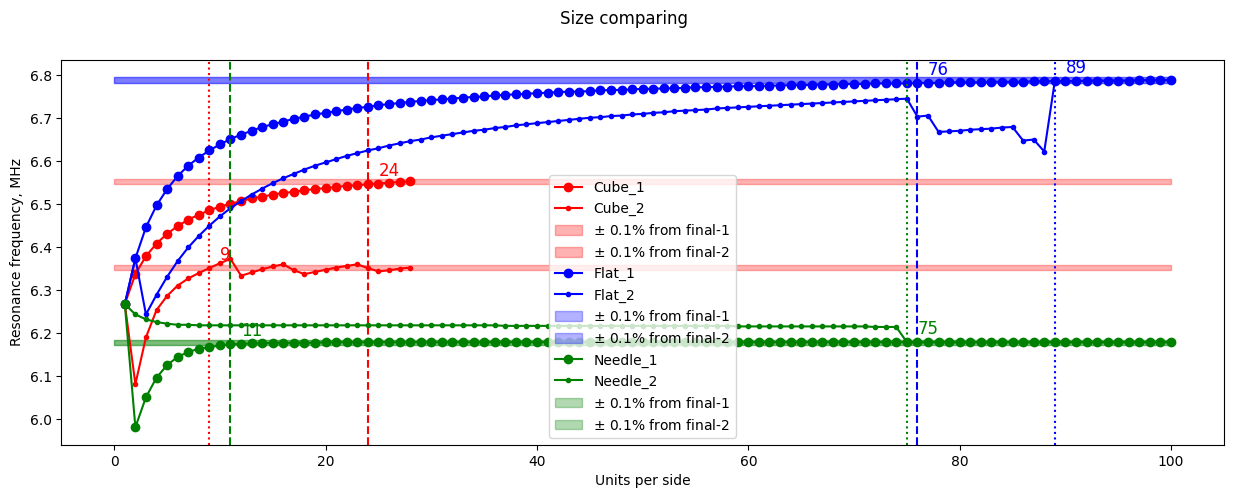

In [17]:
# Compare exact structures
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Compare big, average and small cube structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

N = np.arange(1, 29)
Resounance_Frequence_1 = []  
Resounance_Frequence_2 = []

for n in N:
    Params['N'], Params['shape'] = to3D(n, n, n, 'zyx')
    data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
    Omega = data['Omega']
    ImPol = data['Polarization'][:,0].imag
    peaks, _ = find_peaks(ImPol)
    peak_1 = peaks[np.argmax(ImPol[peaks])]
    peaks = np.delete(peaks, np.argmax(ImPol[peaks]))
    if len(peaks) == 0:
        peak_2 = peak_1
    else:
        peak_2 = peaks[np.argmax(ImPol[peaks])]
    Resounance_Frequence_1.append(max(Omega[peak_1], Omega[peak_2]))
    Resounance_Frequence_2.append(min(Omega[peak_2], Omega[peak_1]))

Resounance_Frequence_1 = np.array(Resounance_Frequence_1)
Resounance_Frequence_2 = np.array(Resounance_Frequence_2)
Limit_Frequence_1 = Resounance_Frequence_1[-1]
Limit_Frequence_2 = Resounance_Frequence_2[-1]
delta_1 = 0.001 * Limit_Frequence_1
delta_2 = 0.001 * Limit_Frequence_2
first_after_1 = N[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]
first_after_2 = N[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]


plt.suptitle('Size comparing')
plt.plot(N, Resounance_Frequence_1/1e6/2/np.pi,
          label = 'Cube_1', color = 'red', marker = 'o')
plt.plot(N, Resounance_Frequence_2/1e6/2/np.pi,
          label = 'Cube_2', color = 'red', marker = '.')
plt.fill_between([0, 100], (Limit_Frequence_1 - delta_1)/1e6/2/np.pi, (Limit_Frequence_1 + delta_1)/1e6/2/np.pi,
                 color = 'red', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-1')
plt.fill_between([0, 100], (Limit_Frequence_2 - delta_2)/1e6/2/np.pi, (Limit_Frequence_2 + delta_2)/1e6/2/np.pi,
                 color = 'red', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-2')
plt.axvline(x=first_after_1, color = 'red', linestyle = '--')
plt.axvline(x=first_after_2, color = 'red', linestyle = ':')
plt.text(first_after_1+1, Resounance_Frequence_1[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_1}', fontsize=12, color='r')
plt.text(first_after_2+1, Resounance_Frequence_2[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_2}', fontsize=12, color='r')

# Compare big, average and small flat structures

N = np.arange(1, 101)
Resounance_Frequence_1 = []  
Resounance_Frequence_2 = []

for n in N:
    Params['N'], Params['shape'] = to3D(1, n, n, 'zyx')
    data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
    Omega = data['Omega']
    ImPol = data['Polarization'][:,0].imag
    peaks, _ = find_peaks(ImPol)
    peak_1 = peaks[np.argmax(ImPol[peaks])]
    peaks = np.delete(peaks, np.argmax(ImPol[peaks]))
    if len(peaks) == 0:
        peak_2 = peak_1
    else:
        peak_2 = peaks[np.argmax(ImPol[peaks])]
    Resounance_Frequence_1.append(Omega[peak_1])
    Resounance_Frequence_2.append(Omega[peak_2])

Resounance_Frequence_1 = np.array(Resounance_Frequence_1)
Resounance_Frequence_2 = np.array(Resounance_Frequence_2)
Limit_Frequence_1 = Resounance_Frequence_1[-1]
Limit_Frequence_2 = Resounance_Frequence_2[-1]
delta_1 = 0.001 * Limit_Frequence_1
delta_2 = 0.001 * Limit_Frequence_2
first_after_1 = N[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]
first_after_2 = N[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]


plt.suptitle('Size comparing')
plt.plot(N, Resounance_Frequence_1/1e6/2/np.pi,
          label = 'Flat_1', color = 'blue', marker = 'o')
plt.plot(N, Resounance_Frequence_2/1e6/2/np.pi,
          label = 'Flat_2', color = 'blue', marker = '.')
plt.fill_between([0, 100], (Limit_Frequence_1 - delta_1)/1e6/2/np.pi, (Limit_Frequence_1 + delta_1)/1e6/2/np.pi,
                 color = 'blue', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-1')
plt.fill_between([0, 100], (Limit_Frequence_2 - delta_2)/1e6/2/np.pi, (Limit_Frequence_2 + delta_2)/1e6/2/np.pi,
                 color = 'blue', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-2')
plt.axvline(x=first_after_1, color = 'blue', linestyle = '--')
plt.axvline(x=first_after_2, color = 'blue', linestyle = ':')
plt.text(first_after_1+1, Resounance_Frequence_1[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_1}', fontsize=12, color='blue')
plt.text(first_after_2+1, Resounance_Frequence_2[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_2}', fontsize=12, color='blue')

# Compare big, average and small needle structures

N = np.arange(1, 101)
Resounance_Frequence_1 = []  
Resounance_Frequence_2 = []

for n in N:
    Params['N'], Params['shape'] = to3D(n, 1, 1, 'zyx')
    data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
    Omega = data['Omega']
    ImPol = data['Polarization'][:,0].imag
    peaks, _ = find_peaks(ImPol)
    peak_1 = peaks[np.argmax(ImPol[peaks])]
    peaks = np.delete(peaks, np.argmax(ImPol[peaks]))
    if len(peaks) == 0:
        peak_2 = peak_1
    else:
        peak_2 = peaks[np.argmax(ImPol[peaks])]
    Resounance_Frequence_1.append(min(Omega[peak_1], Omega[peak_2]))
    Resounance_Frequence_2.append(max(Omega[peak_1], Omega[peak_2]))

Resounance_Frequence_1 = np.array(Resounance_Frequence_1)
Resounance_Frequence_2 = np.array(Resounance_Frequence_2)
Limit_Frequence_1 = Resounance_Frequence_1[-1]
Limit_Frequence_2 = Resounance_Frequence_2[-1]
delta_1 = 0.001 * Limit_Frequence_1
delta_2 = 0.001 * Limit_Frequence_2
first_after_1 = N[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]
first_after_2 = N[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]


plt.suptitle('Size comparing')
plt.plot(N, Resounance_Frequence_1/1e6/2/np.pi,
          label = 'Needle_1', color = 'green', marker = 'o')
plt.plot(N, Resounance_Frequence_2/1e6/2/np.pi,
          label = 'Needle_2', color = 'green', marker = '.')
plt.fill_between([0, 100], (Limit_Frequence_1 - delta_1)/1e6/2/np.pi, (Limit_Frequence_1 + delta_1)/1e6/2/np.pi,
                 color = 'green', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-1')
plt.fill_between([0, 100], (Limit_Frequence_2 - delta_2)/1e6/2/np.pi, (Limit_Frequence_2 + delta_2)/1e6/2/np.pi,
                 color = 'green', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-2')
plt.axvline(x=first_after_1, color = 'green', linestyle = '--')
plt.axvline(x=first_after_2, color = 'green', linestyle = ':')
plt.text(first_after_1+1, Resounance_Frequence_1[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_1}', fontsize=12, color='green')
plt.text(first_after_2+1, Resounance_Frequence_2[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_2}', fontsize=12, color='green')

plt.xlabel('Units per side')
plt.ylabel('Resonance frequency, MHz')
plt.legend()
plt.show()


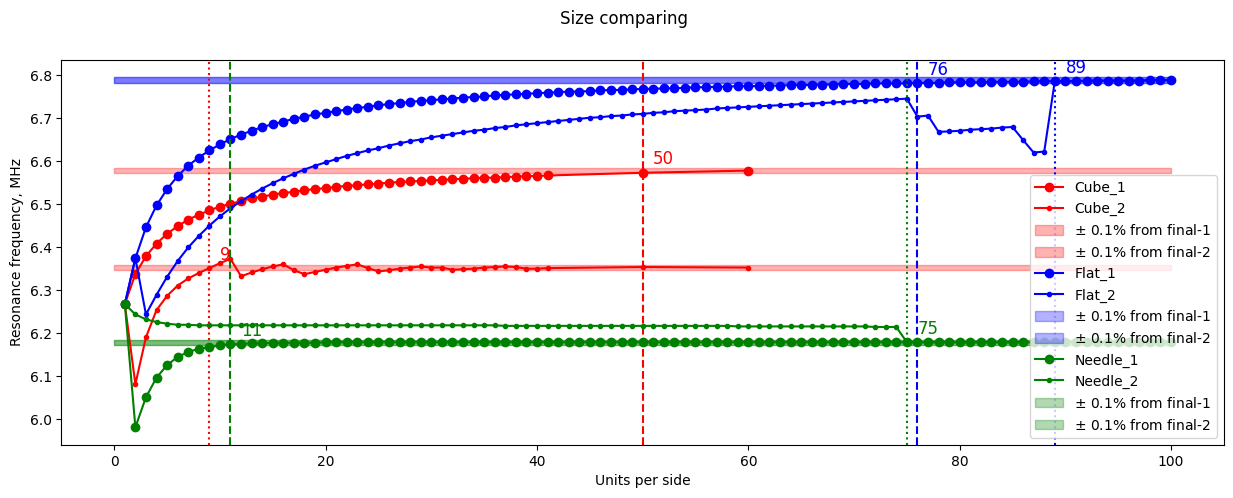

In [46]:
# Compare exact structures
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Compare big, average and small cube structures

plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

N = np.concatenate([np.arange(1, 42), [50, 60]])
Resounance_Frequence_1 = []  
Resounance_Frequence_2 = []

for n in N:
    Params['N'], Params['shape'] = to3D(n, n, n, 'zyx')
    data = open_model('DATALowTol', Params, Currents = 'False', Polarization = 'True')
    Omega = data['Omega']
    ImPol = data['Polarization'][:,0].imag
    peaks, _ = find_peaks(ImPol)
    peak_1 = peaks[np.argmax(ImPol[peaks])]
    peaks = np.delete(peaks, np.argmax(ImPol[peaks]))
    if len(peaks) == 0:
        peak_2 = peak_1
    else:
        peak_2 = peaks[np.argmax(ImPol[peaks])]
    Resounance_Frequence_1.append(max(Omega[peak_1], Omega[peak_2]))
    Resounance_Frequence_2.append(min(Omega[peak_2], Omega[peak_1]))

Resounance_Frequence_1 = np.array(Resounance_Frequence_1)
Resounance_Frequence_2 = np.array(Resounance_Frequence_2)
Limit_Frequence_1 = Resounance_Frequence_1[-1]
Limit_Frequence_2 = Resounance_Frequence_2[-1]
delta_1 = 0.001 * Limit_Frequence_1
delta_2 = 0.001 * Limit_Frequence_2
first_after_1 = N[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]
first_after_2 = N[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]


plt.suptitle('Size comparing')
plt.plot(N, Resounance_Frequence_1/1e6/2/np.pi,
          label = 'Cube_1', color = 'red', marker = 'o')
plt.plot(N, Resounance_Frequence_2/1e6/2/np.pi,
          label = 'Cube_2', color = 'red', marker = '.')
plt.fill_between([0, 100], (Limit_Frequence_1 - delta_1)/1e6/2/np.pi, (Limit_Frequence_1 + delta_1)/1e6/2/np.pi,
                 color = 'red', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-1')
plt.fill_between([0, 100], (Limit_Frequence_2 - delta_2)/1e6/2/np.pi, (Limit_Frequence_2 + delta_2)/1e6/2/np.pi,
                 color = 'red', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-2')
plt.axvline(x=first_after_1, color = 'red', linestyle = '--')
plt.axvline(x=first_after_2, color = 'red', linestyle = ':')
plt.text(first_after_1+1, Resounance_Frequence_1[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_1}', fontsize=12, color='r')
plt.text(first_after_2+1, Resounance_Frequence_2[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_2}', fontsize=12, color='r')

# Compare big, average and small flat structures

N = np.arange(1, 101)
Resounance_Frequence_1 = []  
Resounance_Frequence_2 = []

for n in N:
    Params['N'], Params['shape'] = to3D(1, n, n, 'zyx')
    data = open_model('DATALowTol', Params, Currents = 'False', Polarization = 'True')
    Omega = data['Omega']
    ImPol = data['Polarization'][:,0].imag
    peaks, _ = find_peaks(ImPol)
    peak_1 = peaks[np.argmax(ImPol[peaks])]
    peaks = np.delete(peaks, np.argmax(ImPol[peaks]))
    if len(peaks) == 0:
        peak_2 = peak_1
    else:
        peak_2 = peaks[np.argmax(ImPol[peaks])]
    Resounance_Frequence_1.append(Omega[peak_1])
    Resounance_Frequence_2.append(Omega[peak_2])

Resounance_Frequence_1 = np.array(Resounance_Frequence_1)
Resounance_Frequence_2 = np.array(Resounance_Frequence_2)
Limit_Frequence_1 = Resounance_Frequence_1[-1]
Limit_Frequence_2 = Resounance_Frequence_2[-1]
delta_1 = 0.001 * Limit_Frequence_1
delta_2 = 0.001 * Limit_Frequence_2
first_after_1 = N[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]
first_after_2 = N[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]


plt.suptitle('Size comparing')
plt.plot(N, Resounance_Frequence_1/1e6/2/np.pi,
          label = 'Flat_1', color = 'blue', marker = 'o')
plt.plot(N, Resounance_Frequence_2/1e6/2/np.pi,
          label = 'Flat_2', color = 'blue', marker = '.')
plt.fill_between([0, 100], (Limit_Frequence_1 - delta_1)/1e6/2/np.pi, (Limit_Frequence_1 + delta_1)/1e6/2/np.pi,
                 color = 'blue', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-1')
plt.fill_between([0, 100], (Limit_Frequence_2 - delta_2)/1e6/2/np.pi, (Limit_Frequence_2 + delta_2)/1e6/2/np.pi,
                 color = 'blue', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-2')
plt.axvline(x=first_after_1, color = 'blue', linestyle = '--')
plt.axvline(x=first_after_2, color = 'blue', linestyle = ':')
plt.text(first_after_1+1, Resounance_Frequence_1[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_1}', fontsize=12, color='blue')
plt.text(first_after_2+1, Resounance_Frequence_2[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_2}', fontsize=12, color='blue')

# Compare big, average and small needle structures

N = np.arange(1, 101)
Resounance_Frequence_1 = []  
Resounance_Frequence_2 = []

for n in N:
    Params['N'], Params['shape'] = to3D(n, 1, 1, 'zyx')
    data = open_model('DATALowTol', Params, Currents = 'False', Polarization = 'True')
    Omega = data['Omega']
    ImPol = data['Polarization'][:,0].imag
    peaks, _ = find_peaks(ImPol)
    peak_1 = peaks[np.argmax(ImPol[peaks])]
    peaks = np.delete(peaks, np.argmax(ImPol[peaks]))
    if len(peaks) == 0:
        peak_2 = peak_1
    else:
        peak_2 = peaks[np.argmax(ImPol[peaks])]
    Resounance_Frequence_1.append(min(Omega[peak_1], Omega[peak_2]))
    Resounance_Frequence_2.append(max(Omega[peak_1], Omega[peak_2]))

Resounance_Frequence_1 = np.array(Resounance_Frequence_1)
Resounance_Frequence_2 = np.array(Resounance_Frequence_2)
Limit_Frequence_1 = Resounance_Frequence_1[-1]
Limit_Frequence_2 = Resounance_Frequence_2[-1]
delta_1 = 0.001 * Limit_Frequence_1
delta_2 = 0.001 * Limit_Frequence_2
first_after_1 = N[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]
first_after_2 = N[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]


plt.suptitle('Size comparing')
plt.plot(N, Resounance_Frequence_1/1e6/2/np.pi,
          label = 'Needle_1', color = 'green', marker = 'o')
plt.plot(N, Resounance_Frequence_2/1e6/2/np.pi,
          label = 'Needle_2', color = 'green', marker = '.')
plt.fill_between([0, 100], (Limit_Frequence_1 - delta_1)/1e6/2/np.pi, (Limit_Frequence_1 + delta_1)/1e6/2/np.pi,
                 color = 'green', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-1')
plt.fill_between([0, 100], (Limit_Frequence_2 - delta_2)/1e6/2/np.pi, (Limit_Frequence_2 + delta_2)/1e6/2/np.pi,
                 color = 'green', alpha = 0.3,
                 label = '$\pm$ 0.1% from final-2')
plt.axvline(x=first_after_1, color = 'green', linestyle = '--')
plt.axvline(x=first_after_2, color = 'green', linestyle = ':')
plt.text(first_after_1+1, Resounance_Frequence_1[np.where(np.abs(Resounance_Frequence_1 - Limit_Frequence_1) < delta_1)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_1}', fontsize=12, color='green')
plt.text(first_after_2+1, Resounance_Frequence_2[np.where(np.abs(Resounance_Frequence_2 - Limit_Frequence_2) < delta_2)[0][0]]/1e6/2/np.pi+0.02, f'{first_after_2}', fontsize=12, color='green')

plt.xlabel('Units per side')
plt.ylabel('Resonance frequency, MHz')
plt.legend()
plt.show()

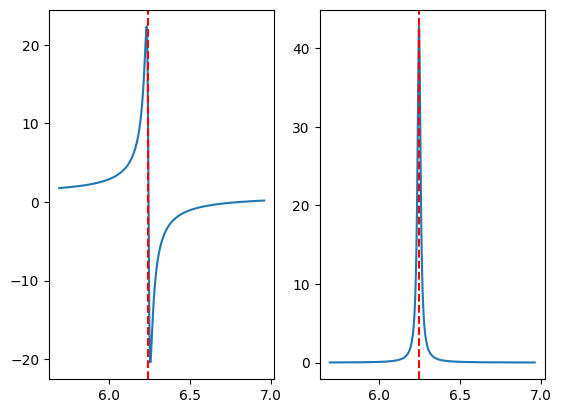

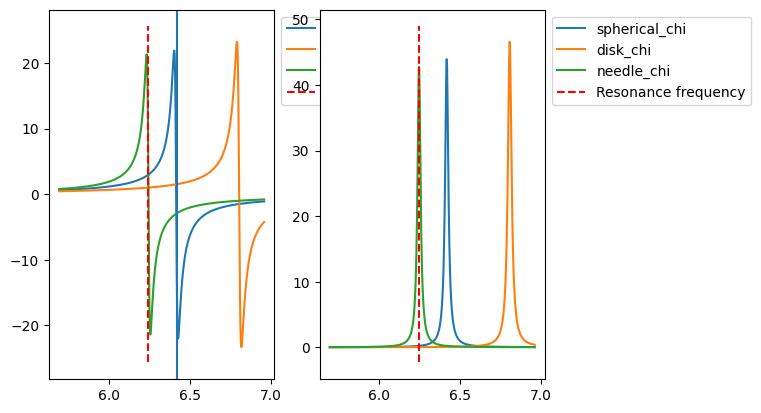

In [47]:
# Theory plotting
from Straight_Method import effective_mu, spherical_chi, needle_chi, disk_chi
MU = effective_mu(Params)(Omega)
omega_res = Omega[find_peaks(MU.imag)[0][0]]
omega_self = 1/np.sqrt(Params['L']*Params['C'])
plt.subplot(121)
plt.plot(Omega/2/np.pi/1e6, MU.real)
plt.axvline(omega_res/2/np.pi/1e6, color = 'red', linestyle = '--', label = 'Resounance_Frequency')
plt.subplot(122)
plt.plot(Omega/2/np.pi/1e6, MU.imag)
plt.axvline(omega_res/2/np.pi/1e6, color = 'red', linestyle = '--', label = 'Resounance_Frequency')
plt.figure()

for theory in [spherical_chi, disk_chi, needle_chi]:
    CHI = theory(MU)
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, CHI.real, label = theory.__name__)
    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, CHI.imag, label = theory.__name__)

plt.subplot(121)
ylim = plt.ylim()
plt.axvline(Omega[576]/2/np.pi/1e6)
plt.vlines(omega_res/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(122)
ylim = plt.ylim()
plt.vlines(omega_res/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



# Drawing GIFs for parameters evolution

 99%|█████████▉| 99/100 [00:30<00:00,  3.12it/s]

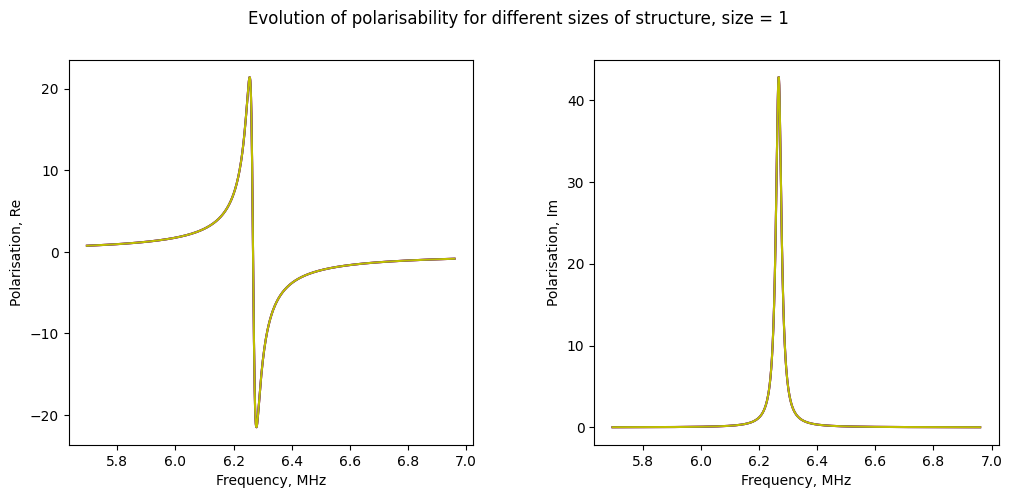

In [18]:
# Compare evolution of polarisability for real and imaginary parts.
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
import matplotlib.animation as anime

fig, ax = plt.subplots()
# Numbers of plots in x and y axes

def plot_GIF(i):
    # Clearing figure and set figsize
    plt.clf()
    fig.set_size_inches(12, 5)

    # Set title and space between plots

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Evolution of polarisability for different sizes of structure, size = {i}")
    
    # Plotting cube
    Params['N'], Params['shape'] = to3D(i, i, i, 'zyx')
    shape_cube = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATA/{name}"):
        data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_cube}', color = 'r')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_cube}', color = 'r')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

    # Plotting flat
    Params['N'], Params['shape'] = to3D(1, i, i, 'zyx')
    shape_flat = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATA/{name}"):
        data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_flat}', color = 'b')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_flat}', color = 'b')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")
    
    # Plotting needle
    Params['N'], Params['shape'] = to3D(i, 1, 1, 'zyx')
    shape_needle = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATA/{name}"):
        data = open_model('DATA', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_needle}', color = 'y')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_needle}', color = 'y')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

        
# Make and save animation object
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = tqdm(range(1, 101)),
                          interval = 50
                          )

ani.save(f'Size_increasing.gif', writer='pillow', fps=5, dpi=100)

  0%|          | 0/100 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [00:52<00:00,  2.08it/s]

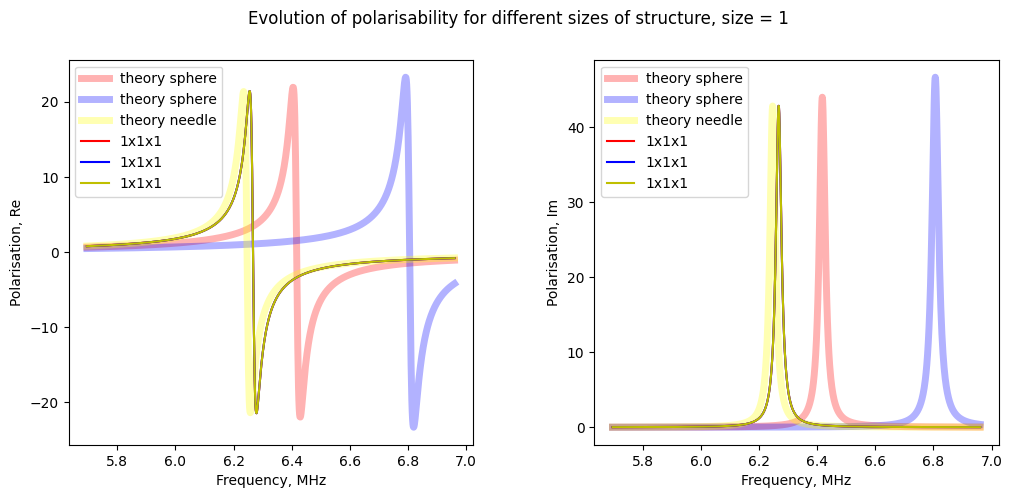

In [53]:
# Compare evolution of polarisability for real and imaginary parts.
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
import matplotlib.animation as anime

fig, ax = plt.subplots()
# Numbers of plots in x and y axes

MU = effective_mu(Params)(Omega)
Sphere = spherical_chi(MU)
Disk = disk_chi(MU)
Needle = needle_chi(MU)

def plot_GIF(i):
    # Clearing figure and set figsize
    plt.clf()
    fig.set_size_inches(12, 5)

    # Set title and space between plots

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"Evolution of polarisability for different sizes of structure, size = {i}")
    plt.subplot(121)
    global Omega
    plt.plot(Omega/2/np.pi/1e6, Sphere.real, alpha=0.3, linewidth = 5, label = 'theory sphere', color = 'red')
    plt.plot(Omega/2/np.pi/1e6, Disk.real, alpha=0.3, linewidth = 5, label = 'theory sphere', color = 'blue')
    plt.plot(Omega/2/np.pi/1e6, Needle.real, alpha=0.3, linewidth = 5, label = 'theory needle', color = 'yellow')
    #plt.axvline(omega_res/2/np.pi/1e6, color = 'black', alpha =0.5, label = 'Resounance_Frequency')
    plt.subplot(122)
    plt.plot(Omega/2/np.pi/1e6, Sphere.imag, alpha=0.3, linewidth = 5, label = 'theory sphere', color = 'red')
    plt.plot(Omega/2/np.pi/1e6, Disk.imag, alpha=0.3, linewidth = 5, label = 'theory sphere', color = 'blue')
    plt.plot(Omega/2/np.pi/1e6, Needle.imag, alpha=0.3, linewidth = 5, label = 'theory needle', color = 'yellow')
    #plt.axvline(omega_res/2/np.pi/1e6, color = 'black', alpha= 0.5, label = 'Resounance_Frequency')
    # Plotting cube
    Params['N'], Params['shape'] = to3D(i, i, i, 'zyx')
    shape_cube = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATALowTol/{name}"):
        data = open_model('DATALowTol', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_cube}', color = 'r')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_cube}', color = 'r')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

    # Plotting flat
    Params['N'], Params['shape'] = to3D(1, i, i, 'zyx')
    shape_flat = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATALowTol/{name}"):
        data = open_model('DATALowTol', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_flat}', color = 'b')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_flat}', color = 'b')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")
    
    # Plotting needle
    Params['N'], Params['shape'] = to3D(i, 1, 1, 'zyx')
    shape_needle = Params['shape']
    name = f'{Params["Packing"]}_NoGrad_{Params["shape"]}_{Params["Orientations"]}_{Params["Solver_type"]}'
    if os.path.exists(f"./DATALowTol/{name}"):
        data = open_model('DATALowTol', Params, Currents = 'False', Polarization = 'True')
        Omega = data['Omega']
        RealPolarisation = data['Polarization'][:, 0].real
        ImagPolarisation = data['Polarization'][:, 0].imag

        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{shape_needle}', color = 'y')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")

        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{shape_needle}', color = 'y')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")
    plt.subplot(121)    
    plt.legend()
    plt.subplot(122)
    plt.legend()

        
# Make and save animation object
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = tqdm(range(1, 101)),
                          interval = 50
                          )

ani.save(f'Size_increasingLowTol.gif', writer='pillow', fps=5, dpi=100)

# Anizotopic anilyse

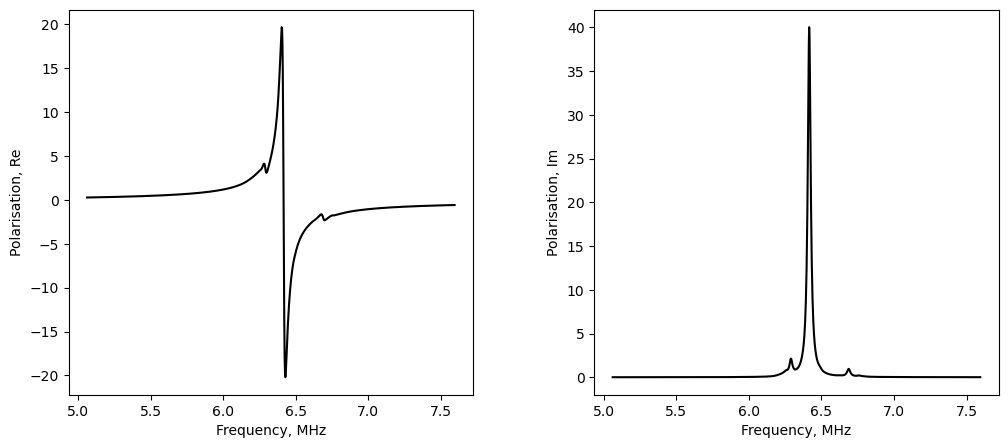

In [5]:
# Plot anizotropoc structure
import json
import numpy as np
import matplotlib.pyplot as plt
from Verifying_MRI.Parameters_MRI import Params
from Straight_Method import effective_mu, spherical_chi, disk_chi, needle_chi
Params['R'] = 0.002
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12*100
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])



for pos in Grad:
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.suptitle(f'Compare anizotropic gradient: {pos}')
    for grad in Grad[pos]:
        with open(f"Data/Grad_Data/anizotropic/Cube/Data-z-20x20x20-{max(grad)}", "r") as f:
            Data = json.load(f)
        Omega = np.array(Data["Omega"])
        RealPolarisation = np.array(Data["RealZPolarisation"]) 
        ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
        plt.subplot(121)
        plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{grad}', linestyle = '-', label = max(grad))
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Re")
    
        plt.subplot(122)
        plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{grad}', linestyle = '-')
        plt.xlabel("Frequency, MHz")
        plt.ylabel("Polarisation, Im")

# Compare maximum gradient in each direction
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.suptitle(f'Compare anizotropic gradient: max')
for pos in Grad:
    with open(f"Data/Grad_Data/anizotropic/Cube/{pos}-grad/Data-z-20x20x20-0.3", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"]) 
    ImagPolarisation = np.array(Data["ImagZPolarisation"]) 
    plt.subplot(121)
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = f'{grad}', linestyle = '-', label = max(grad))
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = f'{grad}', linestyle = '-')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")


# Drawing Currents distribution

In [3]:
# Making GIF for polarisation for different orientations
import numpy as np
import matplotlib.pyplot as plt
from Geometry import to3D
from Calc import open_model
from Parameters import *

# Get Data for plotting
Data = {}

# Needle_length = 12
# for needle_length in range(12, Needle_length+1):
#     Params['Packing'] = 'Rectangle'
#     Params['N'], Params['shape'] = to3D(needle_length, 1, 1, 'zyx')
#     data = open_model('DATA', Params, Currents = 'True', Polarization = 'False')
#     Data[Params['shape']] = data


nz, ny, nx = 50, 50, 50
Params['Packing'] = 'Ellipse'
Params['N'], Params['shape'] = to3D(nz, ny, nx, 'zyx')
Data[f'{nz}x{ny}x{nx}'] = open_model('DATALowTol', Params, Currents = 'True', Polarization = 'True')

print(Data.keys())
    

dict_keys(['50x50x50'])


Saving:  50x50x50 z z 24


MovieWriter imagemagick unavailable; using Pillow instead.
/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_11298/1048720979.py:75: UserWarning: The following kwargs were not used by contour: 'linestyle'
  Lines = plt.contour(X, Y, Currents.T, np.min([len(X), len(Y), 6]), colors = 'black', linestyle='--', alpha = 0.3)
100%|█████████▉| 998/1000 [00:39<00:00, 41.52it/s]MovieWriter imagemagick unavailable; using Pillow instead.
/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_11298/1048720979.py:75: UserWarning: The following kwargs were not used by contour: 'linestyle'
  Lines = plt.contour(X, Y, Currents.T, np.min([len(X), len(Y), 6]), colors = 'black', linestyle='--', alpha = 0.3)
100%|█████████▉| 995/1000 [00:38<00:00, 41.93it/s]

Saving:  50x50x50 z y 24



MovieWriter imagemagick unavailable; using Pillow instead.
/var/folders/tz/kxls6d_s14dblprt_kwm0kf80000gn/T/ipykernel_11298/1048720979.py:75: UserWarning: The following kwargs were not used by contour: 'linestyle'
  Lines = plt.contour(X, Y, Currents.T, np.min([len(X), len(Y), 6]), colors = 'black', linestyle='--', alpha = 0.3)

100%|█████████▉| 999/1000 [00:57<00:00, 17.43it/s]











































































































































































































































































































































































































































































































































































































































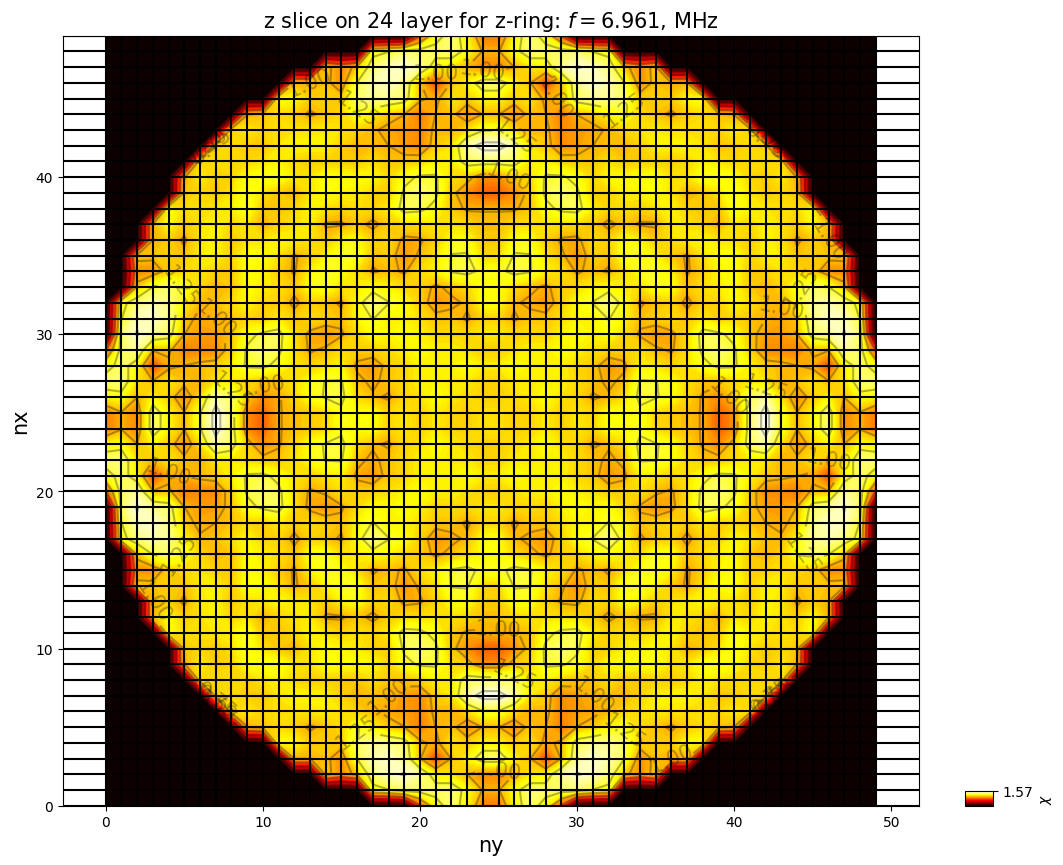

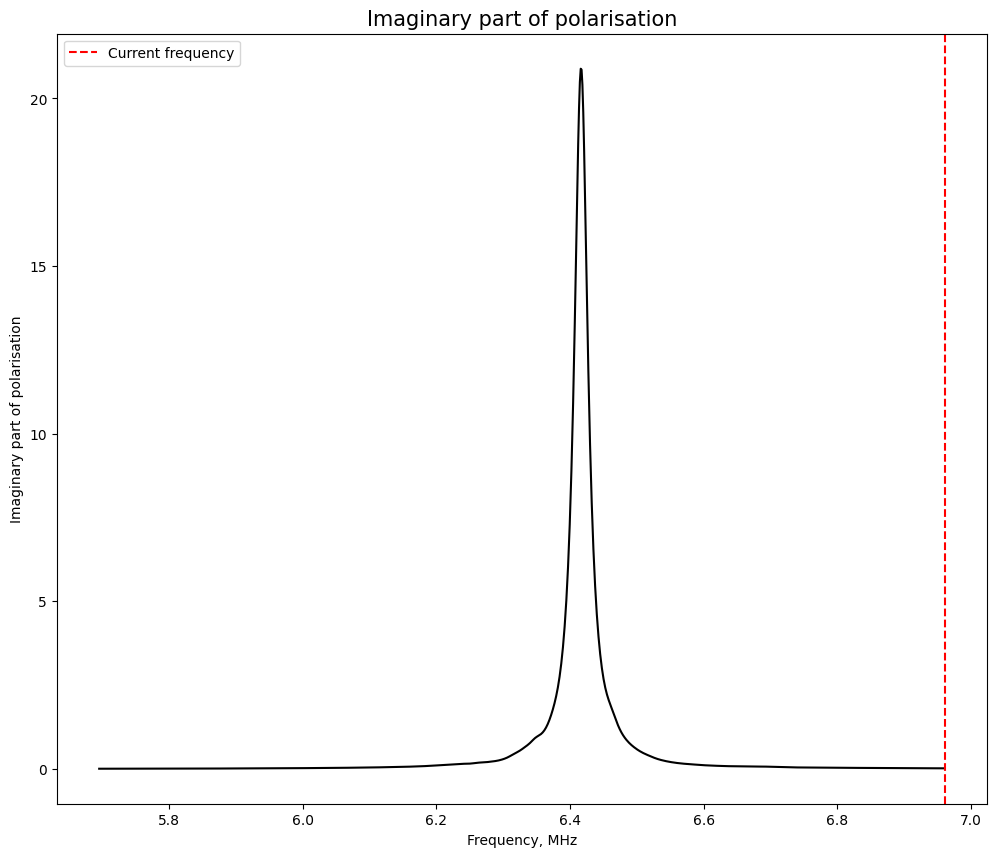

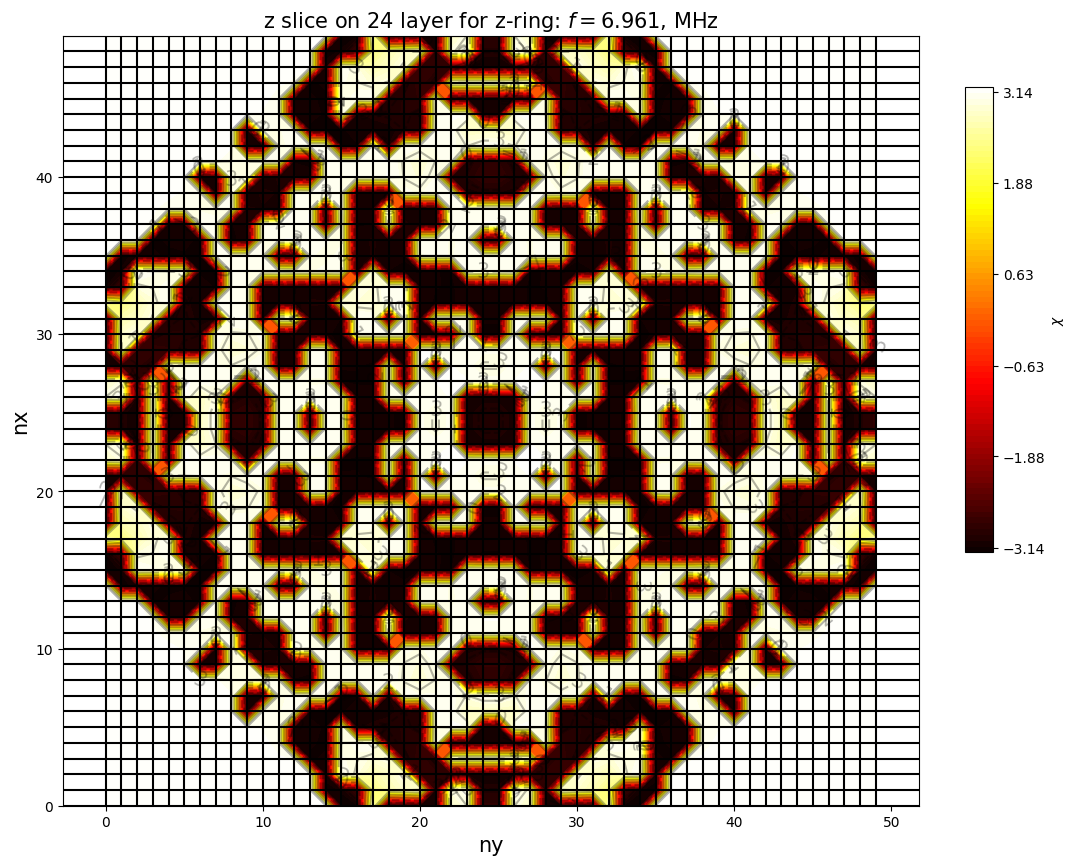

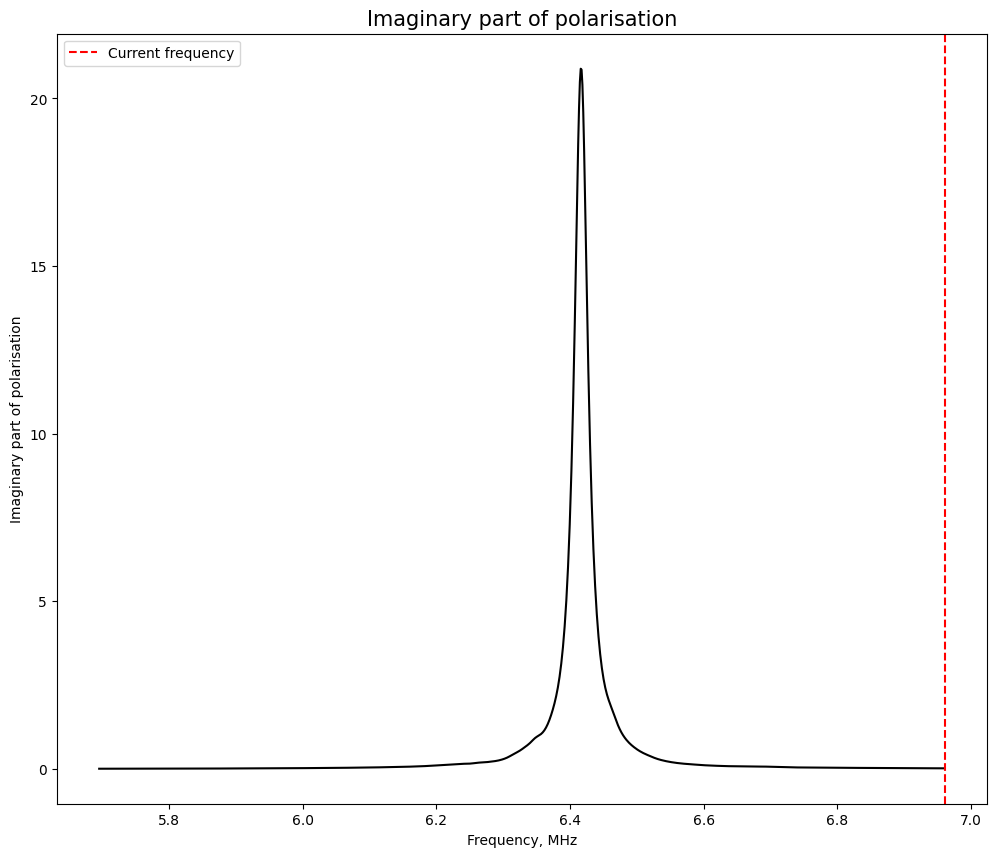

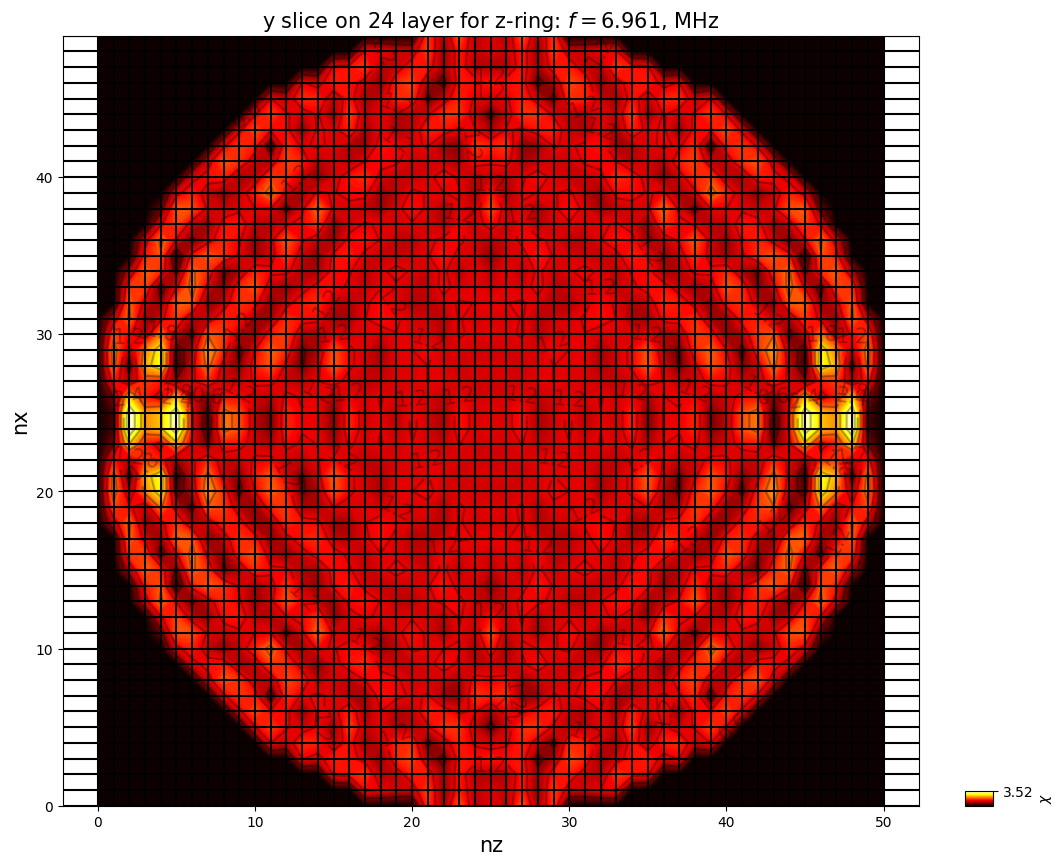

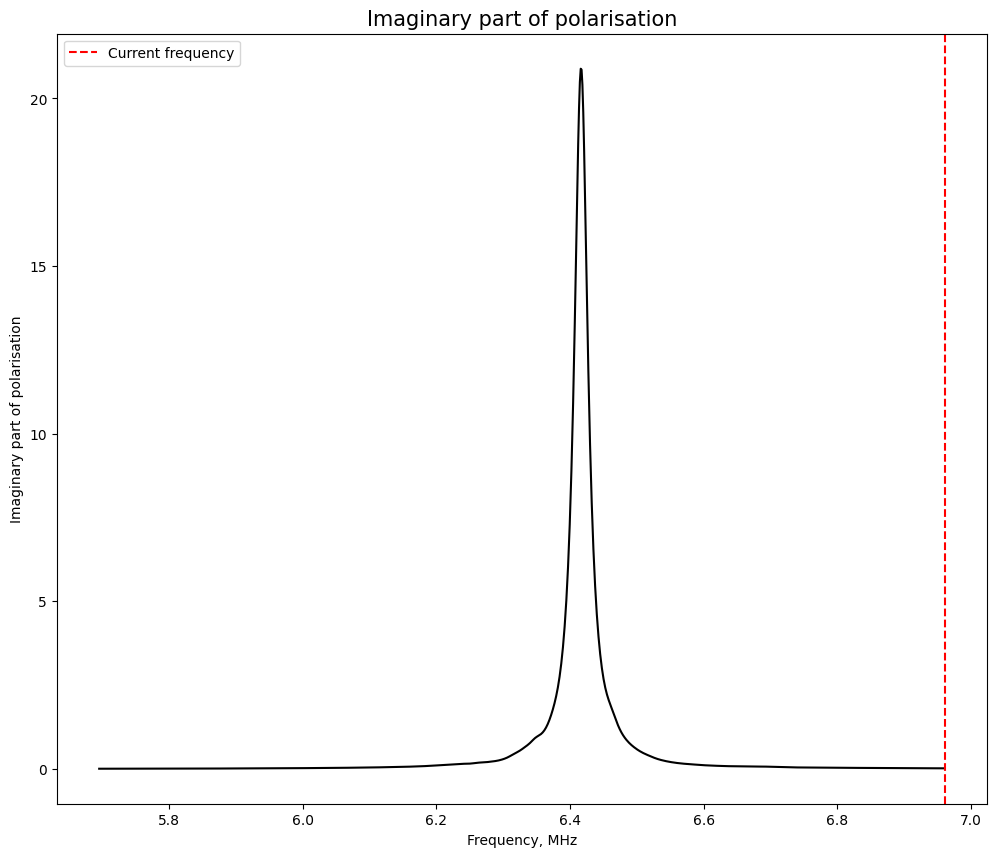

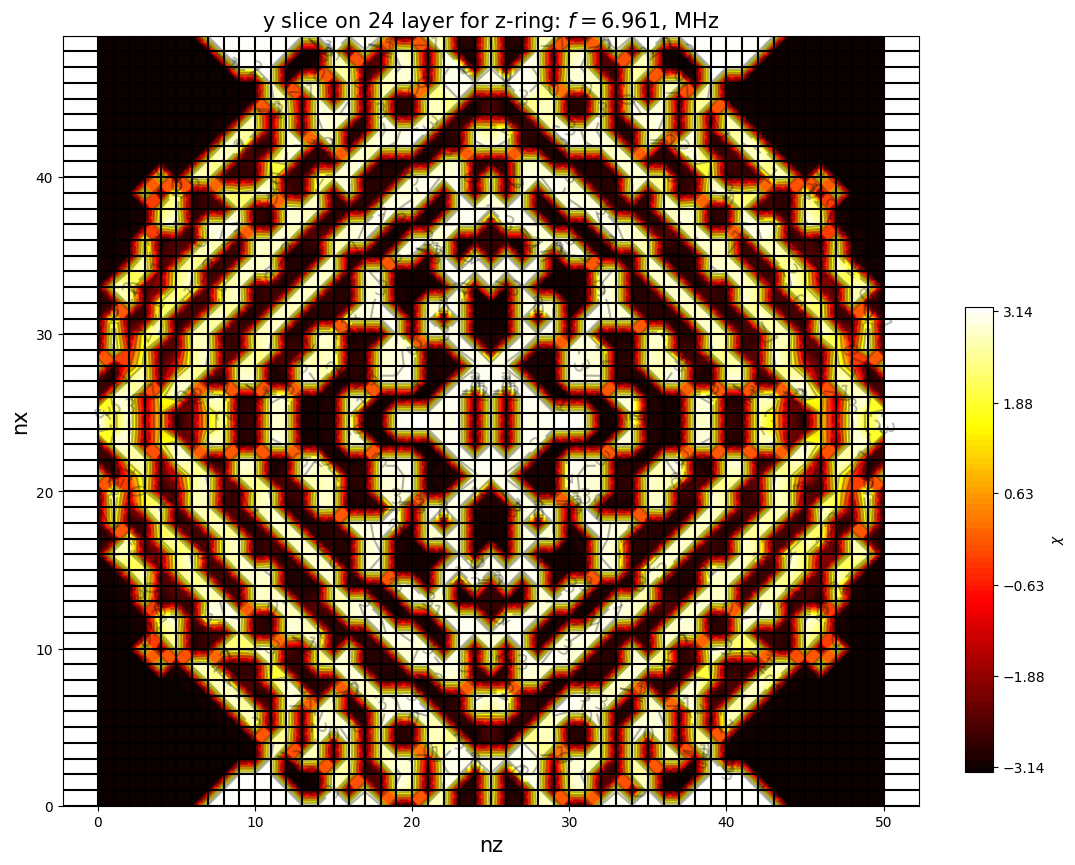

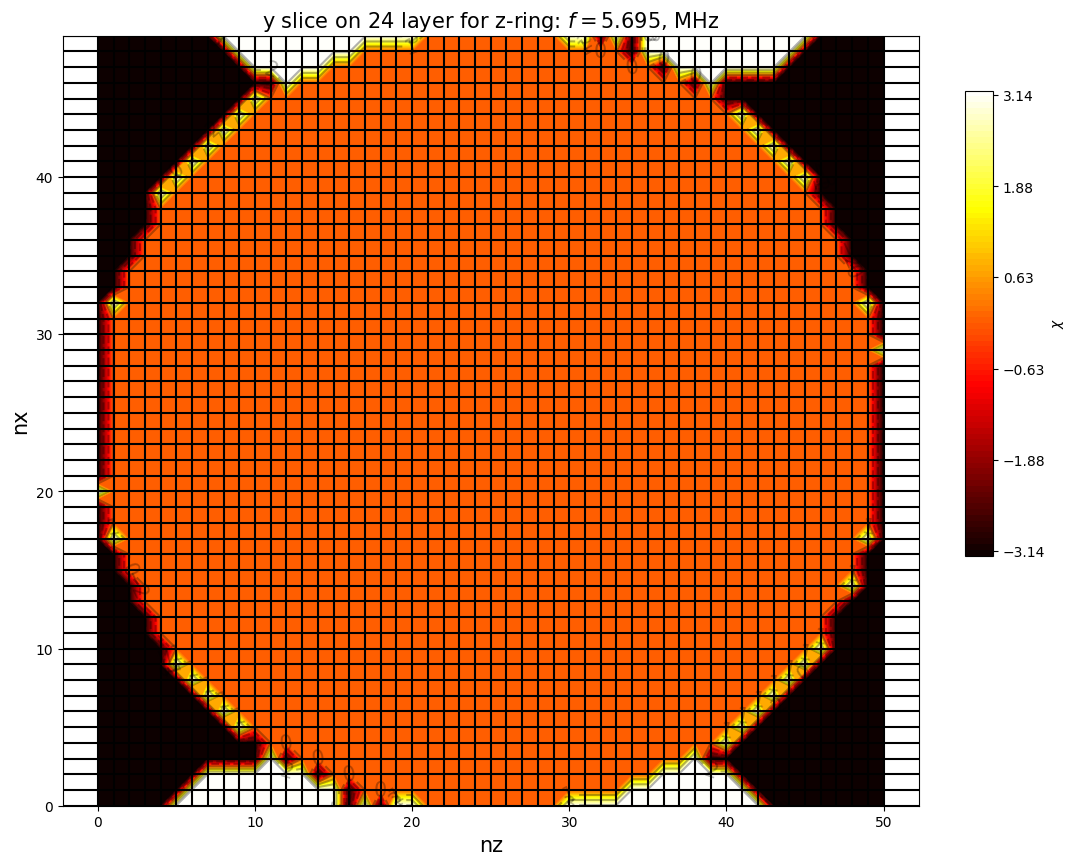

In [4]:
# Calculate polarisation for slices
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as anime
from tqdm import tqdm

# Drawing GIFs
current_part = {
    'abs': lambda x: np.abs(x),
    'real': lambda x: np.real(x),
    'imag': lambda x: np.imag(x),
    'angle': lambda x: np.angle(x)
}

def SaveDistribution(Data, rtype, slice_deep, slice_or, name, mode = 'abs'):
    Currents_4D = Data['Currents']
    ImagPolarisation = Data['Polarization'][:, 0].imag
    Omega = np.array(Data["Omega"])
    part = current_part[mode]
    Params = Data['Params']
    N = Params['N']

    start = 0
    for ring_type in N:
        if ring_type != rtype:
            start += np.prod([N[ring_type][j] for j in N[ring_type]])
        else:
            break
    end = start + np.prod([N[rtype][j] for j in N[rtype]])

    rslice = [slice(slice_deep * (slice_or =='z'), (slice_deep+1)*(slice_or=='z') + N[rtype]['nz'] * (slice_or != 'z'), 1),
      slice(slice_deep * (slice_or =='y'), (slice_deep+1)*(slice_or=='y') + N[rtype]['ny'] * (slice_or != 'y'), 1),
      slice(slice_deep * (slice_or =='x'), (slice_deep+1)*(slice_or=='x') + N[rtype]['nx'] * (slice_or != 'x'), 1)]
    
    shape = [len(Omega)]+[N[rtype][j] for j in N[rtype]]
    squeeze_or = 1 if slice_or == 'z' else 2 if slice_or == 'y' else 3

    # Find currents on slice

    Currents2D = Currents_4D[:,start:end].reshape(shape)[:, *rslice]*Params['P_0z']
    
    # convert 3D data to 2D along slice_or axis
    Currents2D = np.squeeze(part(Currents2D), axis = squeeze_or) 

    # Contourf can't plot 1D data, so we need to repeat it
    if Currents2D.shape[1] == 1:
        Currents2D = np.repeat(Currents2D, 2, axis = 1)
    if Currents2D.shape[2] == 1:
        Currents2D = np.repeat(Currents2D, 2, axis = 2)
    
    
    # Calculate extremums for each slice
    MaxCurrents = Currents2D.max()
    MinCurrents = Currents2D.min()
    MaxDeltaCurrents = MaxCurrents - MinCurrents

    fig_currents, ax_currents = plt.subplots(figsize = (12, 10))
    
    n_1, n_2 = tuple([j for j in N[rtype].keys() if j != f'n{slice_or}'])
    
    X, Y = list(range(N[rtype][n_1])), list(range(N[rtype][n_2]))
    if len(X) == 1:
        X = [0, 1]
    if len(Y) == 1:
        Y = [0, 1]

    def plot_GIF(i):
        plt.clf()
        
        fig_currents.set_size_inches((12, 10))

        Currents = Currents2D[i]
        omega = Omega[i]
        
        Lines = plt.contour(X, Y, Currents.T, np.min([len(X), len(Y), 6]), colors = 'black', linestyle='--', alpha = 0.3)
        
        Imax, Imin = Currents.max(), Currents.min()
        DeltaCurrents = Imax - Imin
        
        amplitude = DeltaCurrents/MaxDeltaCurrents/2
        if amplitude == 0:
            amplitude = 0.01
        if MaxDeltaCurrents - DeltaCurrents == 0:
            middlepos = 0.5
        else:
            middlepos = (Imin-MinCurrents)/(MaxDeltaCurrents - DeltaCurrents)
        ticksnumber = round(amplitude * 10) + 1
        
        ticks = list(map(lambda x: round(np.real(x), 2), np.linspace(Imax, Imin, ticksnumber)))

        plt.xlabel(n_1, fontsize = 15)
        plt.ylabel(n_2, fontsize = 15)
        
        plt.contourf(X, Y, Currents.T, 100, cmap=plt.cm.hot)
        plt.clabel(Lines, inline=1, fontsize=15)
        plt.colorbar(label = r'$\chi$', fraction = 0.03, pad = 0.05, 
                          shrink = 10, aspect = amplitude/0.03, anchor = (0, middlepos),
                          ticks = ticks)
        plt.title(f"{slice_or} slice on {slice_deep} layer for {rtype}-ring: $f =${round(omega/2/np.pi/10 ** 6, 3)}, MHz", fontsize = 15)
        
        plt.axis('equal')
        for x in X:
            plt.axvline(x, color = 'black')
        for y in Y:
            plt.axhline(y, color = 'black')
    
    ani = anime.FuncAnimation(fig_currents, plot_GIF,
                              frames = tqdm(list(range(len(Omega)))[::]),
                              interval = 50
                              )

    ani.save(f'{name}.gif', writer='imagemagick', fps=60)

    fig_pol, ax_pol = plt.subplots(figsize = (12, 10))
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, color = 'black')
    mark = ax_pol.axvline(Omega[0]/2/np.pi/1e6, color = 'red', linestyle = '--', label = 'Current frequency')
    plt.xlabel('Frequency, MHz')
    plt.ylabel('Imaginary part of polarisation')
    plt.legend()
    plt.title('Imaginary part of polarisation', fontsize = 15)

    def plot_pol(i):
        mark.set_xdata([Omega[i]/2/np.pi/10**6])

    ani = anime.FuncAnimation(fig_pol, plot_pol, frames = tqdm(list(range(len(Omega)))[::]), interval = 50)

    ani.save(f'{name}-pol.gif', writer='imagemagick', fps=60)

for shape in Data:
    data = Data[shape]
    l = int(shape.split('x')[0])
    for rtype in ['z']:
        for slice_or in ['z', 'y']:
                slice_deep = 24
                print('Saving: ', shape, rtype, slice_or, slice_deep)
                for mode in ['abs', 'angle']:
                    SaveDistribution(data, rtype, slice_deep, slice_or, f'Plots/Current_distribution/Form/{Params['Packing']}-{shape}-{rtype}ring-{slice_or}slice-{slice_deep}-{Params['Solver_type']}-{mode}', mode = mode)

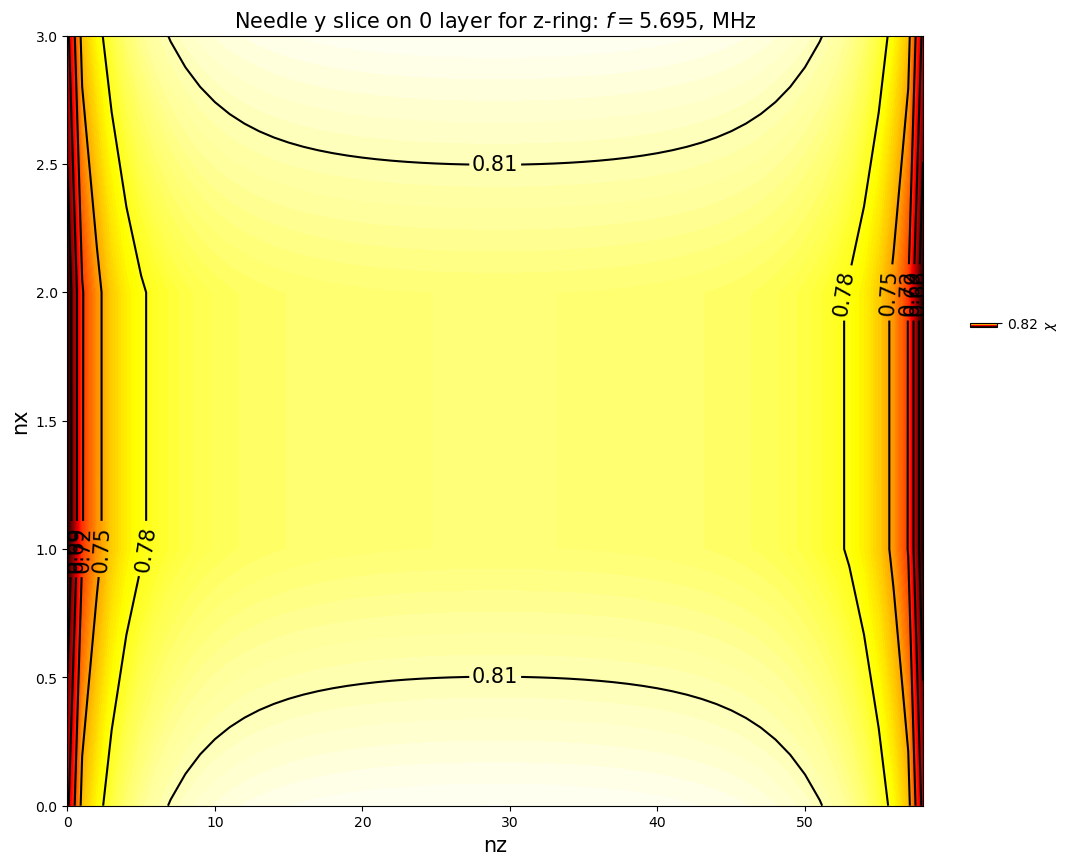

In [32]:
# Calculate and compare polarisation for different structures

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as anime
from tqdm import tqdm

# Drawing GIFs

''' 
- Datas_sets is a dictionary with keys as names of datasets and values as datasets
- rtypes is a list of ring types
- slice_ors is a list of slice orientations
- slice_deeps is a dictionary with keys as tuples (name, rtype, slice_or) and values as lists of slice deeps,
number of slice deeps should be the same for each id
- name is a name of the GIF 
'''
def SaveDistribution(Data_sets, rtypes, slice_ors, slice_deeps, Name):
    
    # Get Data for plotting
    Currents2D = {}
    Omega = {}
    MaxCurrents = {}
    MinCurrents = {}
    MaxDeltaCurrents = {}
    n_1, n_2 = {}, {}
    X, Y = {}, {}

    grid_num = 0
    for name in Data_sets:
        Data = Data_sets[name]
        Omega[name] = np.array(Data["Omega"])
        Currents_4D = np.array(Data["RealCurrents"], dtype = complex) + 1j * np.array(Data["ImagCurrents"], dtype= complex)

        Params = Data['Params']

        Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
        Radius = Params['Radius']
        N = Params['N']
        H_0z = 1

        for rtype in rtypes:
            start = 0
            # Calculate start and end positions for each ring type
            for ring_type in N:
                if ring_type != rtype:
                    start += np.prod([N[ring_type][j] for j in N[ring_type]])
                else:
                    break
            end = start + np.prod([N[rtype][j] for j in N[rtype]])
            
            for slice_or in slice_ors:
                slice_id = (name, rtype, slice_or)
                for slice_deep in slice_deeps[slice_id]:
                    # Calculate position in plotting grid
                    data_pos = 1 + list(Data_sets.keys()).index(name)
                    slice_deep_pos = list(slice_deeps[slice_id]).index(slice_deep) * len(Data_sets)
                    slice_pos = list(slice_ors).index(slice_or) * len(Data_sets) * len(slice_deeps[slice_id])
                    rtype_pos = list(rtypes).index(rtype) * len(Data_sets) * len(slice_ors) * len(slice_deeps[slice_id])

                    grid_num = data_pos + slice_pos + slice_deep_pos + rtype_pos
                    Id = (name, rtype, slice_or, slice_deep, grid_num)
                    
                    # Get current slice for choosen parameters
                    rslice = [slice(slice_deep * (slice_or =='z'), (slice_deep+1)*(slice_or=='z') + N[rtype]['nz'] * (slice_or != 'z'), 1),
                      slice(slice_deep * (slice_or =='y'), (slice_deep+1)*(slice_or=='y') + N[rtype]['ny'] * (slice_or != 'y'), 1),
                      slice(slice_deep * (slice_or =='x'), (slice_deep+1)*(slice_or=='x') + N[rtype]['nx'] * (slice_or != 'x'), 1)]

                    Currents2D[Id] = np.real(np.squeeze(Currents_4D[:,start:end].reshape([len(Omega[name])]+ [N[rtype][j] for j in N[rtype]])[:, *rslice]))*np.pi * Radius ** 2 /Dz/Dy/Dx/H_0z

                    # Calculate extremums for each slice
                    MaxCurrents[Id] = Currents2D[Id].max()
                    MinCurrents[Id] = Currents2D[Id].min()
                    MaxDeltaCurrents[Id] = MaxCurrents[Id] - MinCurrents[Id]

                    n_1[Id], n_2[Id] = tuple([j for j in N[rtype].keys() if j != f'n{slice_or}'])

                    X[Id], Y[Id] = list(range(N[rtype][n_1[Id]])), list(range(N[rtype][n_2[Id]]))
        

    fig, ax = plt.subplots()

    # Numbers of plots in x and y axes

    xn = len(Data_sets) * len(slice_deeps[slice_id])
    yn = len(rtypes) * len(slice_ors) 

    # Figsize
    xsize = xn*12
    ysize = yn*10

    def plot_GIF(i):
        # Clearing figure and set figsize
        plt.clf()
        fig.set_size_inches(xsize, ysize)
        for Id in Currents2D:
            name, rtype, slice_or, slice_deep, grid_num = Id
            
            plt.subplot(yn, xn, grid_num)
            Currents = Currents2D[Id][i]    
            omega = Omega[name][i]

            # Set axes scale and avoid extra long plots

            # Draw same-value lines
            Lines = plt.contour(X[Id], Y[Id], Currents.T, 6, colors = 'black')

            # Calculate max currents to normilze it for spectral max
            Imax, Imin = Currents.max(), Currents.min()
            DeltaCurrents = Imax - Imin
            
            # Calculate length of colorbar
            amplitude = DeltaCurrents/MaxDeltaCurrents[Id]

            if abs((Imin - MinCurrents[Id])/Imin) < 1e-3 and abs((Imax - MaxCurrents[Id])/MaxCurrents[Id]) < 1e-3:
                middlepos = 0
            else:
                middlepos = (Imin-MinCurrents[Id])/(MaxDeltaCurrents[Id] - DeltaCurrents)

            # Calculate number of ticks depended on coloubar length
            ticksnumber = round(amplitude * 10) + 1
            ticks = list(map(lambda x: round(np.real(x), 2), np.linspace(Imax, Imin, ticksnumber)))

            plt.xlabel(n_1[Id], fontsize = 15)
            plt.ylabel(n_2[Id], fontsize = 15)

            # Draw colormap
            plt.contourf(X[Id], Y[Id], Currents.T, 100, cmap=plt.cm.hot)
            plt.clabel(Lines, inline=1, fontsize=15)
            plt.colorbar(label = r'$\chi$', fraction = 0.03, pad = 0.05, 
                              shrink = 10, aspect = amplitude/0.03, anchor = (0, middlepos),
                              ticks = ticks)
            scale = len(Y[Id])/len(X[Id])

            if scale < 1/3:
                ax.set_aspect(1/3)
            elif scale > 3:
                ax.set_aspect(3)
            else:
                ax.set_aspect(scale)
            
            plt.title(f"{name} {slice_or} slice on {slice_deep} layer for {rtype}-ring: $f =${round(omega/2/np.pi/10 ** 6, 3)}, MHz", fontsize = 15)

    # Make and save animation object
    ani = anime.FuncAnimation(fig, plot_GIF,
                              frames = list(range(len(Omega[name]))),
                              interval = 50
                              )

    ani.save(f'{Name}.gif', writer='pillow', fps=24, dpi=80)

Data_sets = {'Needle': Data['10x10x10']}#, 'Straight': Data_straight}
rtypes = ('z')
slice_ors = ('y')
slice_deeps = {}
for name in Data_sets:
    for rtype in rtypes:
        for slice_or in slice_ors:
            slice_deeps[(name, rtype, slice_or)] = [0]
SaveDistribution(Data_sets, rtypes, slice_ors, slice_deeps, f'Plots/Current_distribution/Form/Errors')        

In [24]:
rtype, slice_or = 'x', 'z'
N = {
        'z': {'nz': 11, 'ny':10, 'nx': 10},
        'y': {'nz': 10, 'ny': 11, 'nx': 10},
        'x': {'nz': 10, 'ny': 10, 'nx': 11}
        }
N = {
    'z': { 'nz': 11, 'ny': 10, 'nx': 10},
    'y': { 'nz': 10, 'ny': 11, 'nx': 10},
    'x': { 'nz': 10, 'ny': 10, 'nx': 11}
}
n_1, n_2 = tuple([j for j in N[rtype].keys() if j != f'n{slice_or}'])
print(n_1, n_2)
X, Y = list(range(N[rtype][n_1])), list(range(N[rtype][n_2]))
print(X, Y)
print(X[-1:0:-1])

ny nx
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[9, 8, 7, 6, 5, 4, 3, 2, 1]


MovieWriter imagemagick unavailable; using Pillow instead.


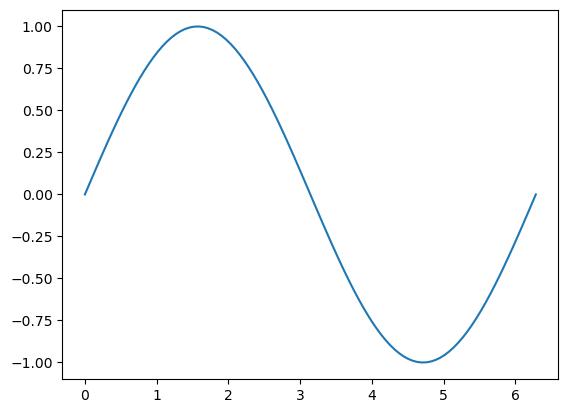

In [4]:

fig, ax = plt.subplots()
def plot_GIF(i):
    ax.clear()
    x = np.linspace(0, 2*np.pi, 100)
    y = np.sin(x + i/10)
    plt.plot(x, y)
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = len(Omega)//10,
                          interval = 50
                          )
ani.save('Plots/Form/CubeSlicingZ.gif', writer='imagemagick', fps=24)

In [65]:
a = {('a', 'b'): slice(1, 2, 3)}
n_1, n_2 = list(a.keys())[0]
rslice = list(a.values())[0]
print(n_1, n_2 , rslice)
a = np.zeros((5, 5, 5))
rslice = [slice(1, 2, 1), slice(1, 2, 1), slice(1, 2, 1)]
print(a[*rslice].shape)

a b slice(1, 2, 3)
(1, 1, 1)
